In [1]:
# Отключаем графический ускоритель
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
from lib.processingutils import *
from lib.graphplot import *

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras_tqdm import TQDMNotebookCallback
from tqdm.keras import TqdmCallback
import random

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12, 6)

### Загружаем и подготавливаем данные ###

In [5]:
version = '1.1.2'
filename = f'~/jlab/data/usdrub_{version}.csv'
#csv_path = '~/notebook_server/data/USDRUB.csv'
usdrub = pd.read_csv(filename)
# задаем период обработки данных
usdrub.index = usdrub['DateTime']
usdrub = usdrub.query("'2020-11-02 08:00:00' <= DateTime < '2022-02-20'")
features_considered = ['LastPriceDIV', 'dTime']
uni_data = usdrub[features_considered]
uni_data = uni_data.values
uni_data_norm = dataset_normalization(uni_data)

In [6]:
# Смотрим распределение данных
#sns.set_style('darkgrid')
#sns_plot = sns.histplot(uni_data_norm[:,0])
#fig = sns_plot.get_figure()
#plt.show()

In [7]:
# Задаем параметры предобработки данных
univariate_past_history = 200
univariate_future_target = 1

uni_data_all = reform_data(dataset=uni_data_norm, 
                            history_size=univariate_past_history,
                            target_size=univariate_future_target,
                            shuffle=False)

Nsamples = len(uni_data_all)
print(f'количество выборок: {Nsamples}')

Подготовка данных: 100%|███████████████████████████████| 2822039/2822039 [01:11<00:00, 39296.30it/s]


количество выборок: 2756031


In [8]:
# Задаем параметры подготовки данных для выгрузки в нейросеть
TRAIN_SPLIT = 0.80
TRAIN_SPLIT = int(Nsamples * TRAIN_SPLIT)

x_uni, y_uni = preparate_data(dataset=uni_data_all, 
                                history_size=univariate_past_history,
                                target_size=univariate_future_target)

x_train_uni = x_uni[:TRAIN_SPLIT]
y_train_uni = y_uni[:TRAIN_SPLIT]

x_val_uni = x_uni[TRAIN_SPLIT:]
y_val_uni = y_uni[TRAIN_SPLIT:]

Подготовка выходных данных: 100%|█████████████████████| 2756031/2756031 [00:04<00:00, 594020.23it/s]


<module 'matplotlib.pyplot' from '/home/gamen/anaconda3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

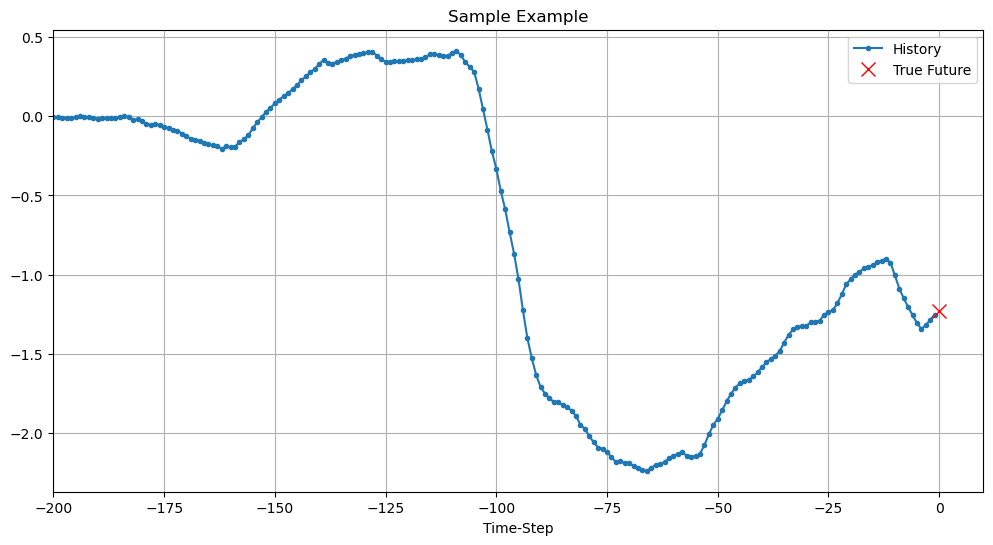

In [9]:
# Отрисовка случайно выбранной выборки
rand_values = random.randint(0, x_train_uni.shape[0])
show_plot([x_train_uni[10], y_train_uni[10]], 0, 'Sample Example')

In [10]:
# Преобразование данных для обработки нейросетью
BATCH_SIZE = 32
#print(x_train_uni.shape[0])
BUFFER_SIZE = 1024

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

2023-02-10 11:52:06.316159: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [11]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(50, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mse')

In [ ]:
EPOCHS = 5
filepath = f'~/jlab/checkpoint/{version}'
#progress = TQDMNotebookCallback(epoch=EPOCHS,
#                         batch_size=BATCH_SIZE,
#                         verbose=1,
#                         tqdm_class=tqdm_auto)

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
                                            monitor='val_loss',
                                            verbose=1,
                                            save_best_only=False,
                                            save_weights_only=False,
                                            mode='auto',
                                            save_freq='epoch',
                                            options=None,
                                            initial_value_threshold=None)

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                    steps_per_epoch=int(x_train_uni.shape[0]//BATCH_SIZE),
                    validation_data=val_univariate, validation_steps=int(x_val_uni.shape[0]//BATCH_SIZE),
                     workers=4, use_multiprocessing=True, verbose=1, callbacks=[progress, checkpoint])

simple_lstm_model.save(f'~/jlab/result/{version}')

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]